In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import random, os, pathlib, time
from tqdm import tqdm
from sklearn import datasets

In [2]:
device = torch.device("cuda:1")
# device = torch.device("cpu")

## MNIST dataset

In [3]:
import mylibrary.datasets as datasets
import mylibrary.nnlib as tnn

In [4]:
mnist = datasets.FashionMNIST()
# mnist.download_mnist()
# mnist.save_mnist()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

# train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label_)

In [5]:
## converting data to pytorch format
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)
train_label = torch.LongTensor(train_label_)
test_label = torch.LongTensor(test_label_)

In [6]:
input_size = 784
output_size = 10

In [7]:
class MNIST_Dataset(data.Dataset):
    
    def __init__(self, data, label):
        self.data = data
        self.label = label
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img, lbl = self.data[idx], self.label[idx]
        return img, lbl

In [8]:
train_dataset = MNIST_Dataset(train_data, train_label)
test_dataset = MNIST_Dataset(test_data, test_label)

In [9]:
batch_size = 50
train_loader = data.DataLoader(dataset=train_dataset,
                                    num_workers=4, 
                                    batch_size=batch_size, 
                                    shuffle=True)

test_loader = data.DataLoader(dataset=test_dataset,
                                    num_workers=4, 
                                    batch_size=batch_size, 
                                    shuffle=False)

In [10]:
class DistanceTransform(nn.Module):
    
    def __init__(self, input_dim, num_centers):
        super().__init__()
        self.input_dim = input_dim
        self.num_centers = num_centers
        
        self.centers = torch.randn(num_centers, input_dim)/3.
        self.centers = nn.Parameter(self.centers)
        
    def forward(self, x):
        x = x[:, :self.input_dim]
        dists = torch.cdist(x, self.centers)
#         print(dists.shape)
#         dists = dists/np.sqrt(self.input_dim) ### correction to make diagonal of unit square 1 in nD space
        return dists
    
    def reverse(self, x):
        ### here x is the distance, so weighted distance is the reversed mode
        ##### for a single input, y = mean(x_i * center_i : for i in range(num_centers))
        pass

In [11]:
dt = DistanceTransform(784, 784)

In [12]:
list(dt.parameters())

[Parameter containing:
 tensor([[ 0.0213, -0.4219,  0.1136,  ...,  0.1285,  0.0714,  0.3266],
         [ 0.0413,  0.6386, -0.1105,  ...,  0.2163,  0.0627,  0.1087],
         [ 0.5310, -0.1246,  0.2344,  ..., -0.0380,  0.2749, -0.1126],
         ...,
         [ 0.2721, -0.0692,  0.4037,  ...,  0.0917,  0.4110,  0.0136],
         [-0.5526, -0.4452,  0.0547,  ...,  0.2828,  0.3244, -0.1131],
         [ 0.1236, -0.2258, -0.1303,  ..., -0.0604,  0.7614,  0.1895]],
        requires_grad=True)]

In [13]:
dt(torch.randn(2, 784)).shape

torch.Size([2, 784])

In [14]:
x=train_dataset[[3,7]][0]
dists = dt(x)
x.std(), dists.std()

(tensor(0.3944), tensor(4.4101, grad_fn=<StdBackward>))

In [15]:
dists.max(), dists.min()

(tensor(23.0945, grad_fn=<MaxBackward1>),
 tensor(12.5703, grad_fn=<MinBackward1>))

In [16]:
dt.centers.shape

torch.Size([784, 784])

In [17]:
### single variable inverse
x = torch.randn(1, 2)
x

tensor([[-0.1870, -1.4669]])

In [18]:
centers = torch.randn(2, 2) ## output_dim / num_centers, input_dim
y = torch.cdist(x, centers.t())  
y.shape

torch.Size([1, 2])

In [19]:
y

tensor([[2.0657, 1.6071]])

In [20]:
weighted_sum = 0
weight = (1/y).sum()
for i in range(len(centers)):
    weighted_sum += centers[i]*(1/y[0,i])/weight
weighted_sum

tensor([0.3948, 0.2222])

In [21]:
##### test for inverse
x = torch.randn(2, 4)

In [22]:
centers = torch.randn(4, 4) ## output_dim / num_centers, input_dim
y = torch.cdist(x, centers)  
y.shape

torch.Size([2, 4])

In [23]:
y

tensor([[2.9806, 2.5053, 3.0376, 3.8804],
        [2.5502, 2.7443, 3.1574, 4.5314]])

In [24]:
(y.unsqueeze(2)*centers).shape

torch.Size([2, 4, 4])

In [25]:
z = (y.unsqueeze(2)*centers.t()).sum(dim=2)/y.sum(dim=1, keepdim=True)
z.shape

torch.Size([2, 4])

In [26]:
z

tensor([[0.7494, 0.3307, 0.0929, 0.3963],
        [0.6126, 0.3460, 0.0923, 0.4421]])

In [27]:
x

tensor([[-1.2697,  1.0953, -0.0219, -1.5452],
        [-1.2804, -1.1382,  1.5585, -0.4854]])

In [443]:
model = nn.Sequential(
                DistanceTransform(784, 784),
                nn.BatchNorm1d(784),
                nn.Linear(784, 200),
                nn.LeakyReLU(),
                nn.Linear(200, 50),
                nn.LeakyReLU(),
                nn.Linear(50, 10))
model.to(device)

Sequential(
  (0): DistanceTransform()
  (1): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=784, out_features=200, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=200, out_features=50, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=50, out_features=10, bias=True)
)

In [444]:
optimizer = optim.Adam(list(model.parameters()), 
                            lr=0.0003, weight_decay=1e-15)
criterion = nn.CrossEntropyLoss()

In [711]:
index = 0
train_accs, test_accs = [], []
model.train()
for epoch in tqdm(list(range(40))):
    train_acc = 0
    train_count = 0
    for xx, yy in train_loader:
        xx, yy = xx.to(device), yy.to(device)
        yout = model(xx)
        loss = criterion(yout, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
        correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
        train_acc += correct
        train_count += len(outputs)

    train_accs.append(float(train_acc)/train_count*100)
    train_acc = 0
    train_count = 0

    print(f'Epoch: {epoch}:{index},  Loss:{float(loss)}')
    test_count = 0
    test_acc = 0
    for xx, yy in test_loader:
        xx, yy = xx.to(device), yy.to(device)
        with torch.no_grad():
            yout = model(xx)
        outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
        correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
        test_acc += correct
        test_count += len(xx)
    test_accs.append(float(test_acc)/test_count*100)
    print(f'Train Acc:{train_accs[-1]:.2f}%, Test Acc:{test_accs[-1]:.2f}%')
    print()

### after each class index is finished training
print(f'\t-> MAX Train Acc {max(train_accs)} ; Test Acc {max(test_accs)}')

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0:0,  Loss:0.21884943544864655


  2%|▎         | 1/40 [00:03<02:28,  3.80s/it]

Train Acc:87.86%, Test Acc:86.08%

Epoch: 1:0,  Loss:0.35980114340782166


  5%|▌         | 2/40 [00:07<02:20,  3.70s/it]

Train Acc:87.97%, Test Acc:86.10%

Epoch: 2:0,  Loss:0.6114858388900757


  8%|▊         | 3/40 [00:11<02:16,  3.69s/it]

Train Acc:88.11%, Test Acc:86.05%

Epoch: 3:0,  Loss:0.3910781145095825


 10%|█         | 4/40 [00:14<02:14,  3.73s/it]

Train Acc:88.07%, Test Acc:86.17%

Epoch: 4:0,  Loss:0.34272444248199463


 12%|█▎        | 5/40 [00:18<02:12,  3.78s/it]

Train Acc:88.22%, Test Acc:86.12%

Epoch: 5:0,  Loss:0.4161618947982788


 15%|█▌        | 6/40 [00:22<02:07,  3.75s/it]

Train Acc:88.35%, Test Acc:85.97%

Epoch: 6:0,  Loss:0.24794156849384308


 18%|█▊        | 7/40 [00:26<02:05,  3.79s/it]

Train Acc:88.46%, Test Acc:86.16%

Epoch: 7:0,  Loss:0.3071301579475403


 20%|██        | 8/40 [00:30<02:01,  3.79s/it]

Train Acc:88.44%, Test Acc:86.53%

Epoch: 8:0,  Loss:0.42635661363601685


 22%|██▎       | 9/40 [00:33<01:58,  3.81s/it]

Train Acc:88.52%, Test Acc:85.74%

Epoch: 9:0,  Loss:0.2583214044570923


 25%|██▌       | 10/40 [00:37<01:52,  3.77s/it]

Train Acc:88.72%, Test Acc:86.31%

Epoch: 10:0,  Loss:0.2158435583114624


 28%|██▊       | 11/40 [00:41<01:48,  3.73s/it]

Train Acc:88.65%, Test Acc:86.21%

Epoch: 11:0,  Loss:0.1795480102300644


 30%|███       | 12/40 [00:45<01:45,  3.77s/it]

Train Acc:88.77%, Test Acc:86.62%

Epoch: 12:0,  Loss:0.3396962881088257


 32%|███▎      | 13/40 [00:49<01:42,  3.80s/it]

Train Acc:88.80%, Test Acc:86.48%

Epoch: 13:0,  Loss:0.2728559672832489


 35%|███▌      | 14/40 [00:52<01:39,  3.82s/it]

Train Acc:88.80%, Test Acc:86.30%

Epoch: 14:0,  Loss:0.27088984847068787


 38%|███▊      | 15/40 [00:56<01:35,  3.81s/it]

Train Acc:88.93%, Test Acc:86.49%

Epoch: 15:0,  Loss:0.32531920075416565


 40%|████      | 16/40 [01:00<01:31,  3.82s/it]

Train Acc:89.04%, Test Acc:86.59%

Epoch: 16:0,  Loss:0.2344987839460373


 42%|████▎     | 17/40 [01:04<01:27,  3.82s/it]

Train Acc:89.16%, Test Acc:86.62%

Epoch: 17:0,  Loss:0.2625880539417267


 45%|████▌     | 18/40 [01:08<01:23,  3.78s/it]

Train Acc:89.21%, Test Acc:86.29%

Epoch: 18:0,  Loss:0.5659687519073486


 48%|████▊     | 19/40 [01:12<01:20,  3.84s/it]

Train Acc:89.11%, Test Acc:86.61%

Epoch: 19:0,  Loss:0.29146260023117065


 50%|█████     | 20/40 [01:15<01:16,  3.85s/it]

Train Acc:89.34%, Test Acc:86.73%

Epoch: 20:0,  Loss:0.4199248254299164


 52%|█████▎    | 21/40 [01:19<01:14,  3.92s/it]

Train Acc:89.25%, Test Acc:86.83%

Epoch: 21:0,  Loss:0.23996968567371368


 55%|█████▌    | 22/40 [01:23<01:10,  3.91s/it]

Train Acc:89.31%, Test Acc:86.95%

Epoch: 22:0,  Loss:0.4564351737499237


 57%|█████▊    | 23/40 [01:27<01:07,  3.97s/it]

Train Acc:89.35%, Test Acc:86.29%

Epoch: 23:0,  Loss:0.21079587936401367


 60%|██████    | 24/40 [01:31<01:03,  3.99s/it]

Train Acc:89.46%, Test Acc:86.82%

Epoch: 24:0,  Loss:0.2069498896598816


 62%|██████▎   | 25/40 [01:36<01:00,  4.02s/it]

Train Acc:89.66%, Test Acc:87.07%

Epoch: 25:0,  Loss:0.2781498432159424


 65%|██████▌   | 26/40 [01:40<00:56,  4.03s/it]

Train Acc:89.68%, Test Acc:86.71%

Epoch: 26:0,  Loss:0.3697288930416107


 68%|██████▊   | 27/40 [01:44<00:52,  4.02s/it]

Train Acc:89.58%, Test Acc:86.64%

Epoch: 27:0,  Loss:0.21431514620780945


 70%|███████   | 28/40 [01:48<00:48,  4.05s/it]

Train Acc:89.72%, Test Acc:87.06%

Epoch: 28:0,  Loss:0.2366712987422943


 72%|███████▎  | 29/40 [01:52<00:44,  4.07s/it]

Train Acc:89.83%, Test Acc:86.97%

Epoch: 29:0,  Loss:0.17135675251483917


 75%|███████▌  | 30/40 [01:56<00:41,  4.12s/it]

Train Acc:89.74%, Test Acc:86.88%

Epoch: 30:0,  Loss:0.5288516879081726


 78%|███████▊  | 31/40 [02:00<00:37,  4.12s/it]

Train Acc:89.90%, Test Acc:86.64%

Epoch: 31:0,  Loss:0.2732090353965759


 80%|████████  | 32/40 [02:04<00:33,  4.15s/it]

Train Acc:90.09%, Test Acc:87.07%

Epoch: 32:0,  Loss:0.16075606644153595


 82%|████████▎ | 33/40 [02:08<00:28,  4.12s/it]

Train Acc:90.03%, Test Acc:87.10%

Epoch: 33:0,  Loss:0.15422211587429047


 85%|████████▌ | 34/40 [02:12<00:24,  4.08s/it]

Train Acc:90.14%, Test Acc:87.16%

Epoch: 34:0,  Loss:0.20754583179950714


 88%|████████▊ | 35/40 [02:17<00:20,  4.10s/it]

Train Acc:90.11%, Test Acc:86.99%

Epoch: 35:0,  Loss:0.26415708661079407


 90%|█████████ | 36/40 [02:20<00:16,  4.02s/it]

Train Acc:90.16%, Test Acc:87.37%

Epoch: 36:0,  Loss:0.1677238792181015


 92%|█████████▎| 37/40 [02:24<00:12,  4.02s/it]

Train Acc:90.22%, Test Acc:87.03%

Epoch: 37:0,  Loss:0.2715015113353729


 95%|█████████▌| 38/40 [02:28<00:08,  4.02s/it]

Train Acc:90.26%, Test Acc:87.09%

Epoch: 38:0,  Loss:0.19740194082260132


 98%|█████████▊| 39/40 [02:33<00:04,  4.06s/it]

Train Acc:90.33%, Test Acc:87.16%

Epoch: 39:0,  Loss:0.5171658992767334


100%|██████████| 40/40 [02:37<00:00,  3.93s/it]

Train Acc:90.35%, Test Acc:87.18%

	-> MAX Train Acc 90.34666666666666 ; Test Acc 87.37


In [35]:
# -> MAX Train Acc 87.678 ; Test Acc 85.87  ### after distance transformation
# -> MAX Train Acc 97.255 ; Test Acc 89.01  ### normal nn

In [446]:
model.eval()
dists = model[0](train_dataset[[0,3,7]][0].to(device))
dists = model[1](dists)
model.train()
dists.shape

torch.Size([3, 784])

In [447]:
dists.mean()

tensor(0.8696, device='cuda:1', grad_fn=<MeanBackward0>)

In [448]:
dists.std()

tensor(1.4066, device='cuda:1', grad_fn=<StdBackward>)

In [449]:
dists[0]

tensor([ 1.2937,  1.2625,  0.4058,  1.3024,  0.7606,  1.1799,  0.7924,  1.0150,
         0.6441,  1.0020,  1.1353,  0.7150,  0.4322,  0.6650,  1.2677,  1.3783,
         1.0093,  0.7190,  1.5132,  1.2309,  1.2599,  1.3139,  0.9065,  0.7099,
         0.4803,  0.4657,  0.4847,  1.4775,  0.7608,  0.8618,  0.3377,  1.0155,
         1.2679,  1.2067,  0.6114,  0.5598,  0.8746,  1.5978,  1.5515,  1.4270,
         0.8973,  0.7935,  0.4619,  1.1910,  0.6426,  1.5839,  1.2299,  0.7975,
         1.3564,  1.1978,  1.0868,  0.5425,  1.0749,  0.8889,  0.7277,  0.5356,
         0.5043,  0.4221,  0.6619,  0.9351,  0.6166,  0.4689,  1.0118,  0.7507,
         1.4633,  1.3519,  0.3987,  1.0880,  0.7220,  0.6949,  1.1703,  1.1805,
         0.5794,  1.4205,  0.1715,  0.7432,  0.5902,  1.0467,  1.1639,  1.4650,
         1.3622,  0.8361,  1.0030,  0.7113,  0.4367,  0.7128,  1.7238,  1.4661,
         1.2387,  0.6737,  0.5589,  1.1626,  1.1422,  1.4981,  0.8619,  1.0330,
         0.6657,  1.4915,  0.6137,  0.97

## Generate adversarial example

In [450]:
_xx, _tt = iter(train_loader).next()

tensor(2)

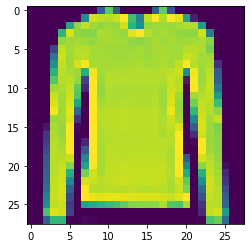

In [766]:
i = 30
plt.imshow(_xx[i].reshape(28,28))
_tt[i]

In [767]:
xx = _xx[i:i+1,:]
tt = _tt[i:i+1]

target_class = 0
advt = tt*0+target_class

In [768]:
model.eval()

X = torch.autograd.Variable(xx, requires_grad=True)
yy = model(X.to(device))

In [769]:
torch.argmax(yy.data.cpu(), dim=1), tt, advt

(tensor([2]), tensor([2]), tensor([0]))

In [770]:
loss = criterion(yy, advt.to(device))

xx_grad = torch.autograd.grad(outputs=loss, inputs=X,
#                             grad_outputs=torch.ones_like(self.Y),
                            only_inputs=True, retain_graph=True, create_graph=True)[0]

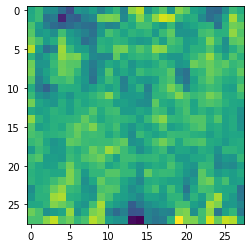

In [771]:
plt.imshow(xx_grad.data.cpu().reshape(28,28))

In [779]:
signed_grad = torch.sign(xx_grad.data.cpu())
# signed_grad = xx_grad.data.cpu()

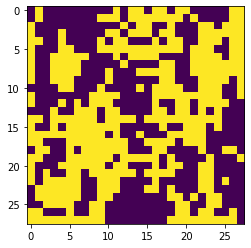

In [780]:
plt.imshow(signed_grad.reshape(28,28))

In [786]:
epsilon = 0.1
pertubation = xx - epsilon*signed_grad
xx_adv = pertubation
xx_adv = torch.clamp(pertubation, 0, 1)

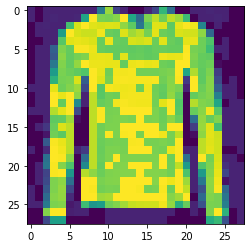

In [787]:
plt.imshow(xx_adv.reshape(28,28))

In [788]:
yy_adv = model(xx_adv.to(device))

In [789]:
yy_adv.argmax(dim=1)

tensor([6], device='cuda:1')

In [785]:
tt

tensor([2])